In [1]:
# IMPORT PACKAGES

import numpy as np
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
#===============================================================================================================================
# OPTIONS
#===============================================================================================================================

# directory
directory = "1D_models_2kh"

# initial model
initial_model = "initial_2k"

# calculate an average of the inverted models
calc_avg = True
avg_name = "avg_2k.vel"


In [3]:
# DEFINE FILEPATHS

parent_dir = "/raid4/hra35"
models_path = os.path.join(parent_dir, directory)

input_model_path = os.path.join(models_path, "%s.vel" %initial_model)
esme_model_path = os.path.join(models_path, "esme_2k.vel")

random_models_path = os.path.join(models_path, "random_models") # directory containing the random models generated from input model  
inverted_models_path = os.path.join(models_path, "inverted_models") # directory containing models generated from inverting the random models
vgrids_path = os.path.join(models_path, "vgrids") # directory containing velociy grid files from the pseudo-1D inversions

picks_path = "/home/hra35/Documents/events/nll_script_outputs/1D_inversion/all_picks.txt" # picks entering the 1D inversion

# list all grid files
p_grid_files = glob.glob(os.path.join(vgrids_path, "vgrids_p_*.in"))
p_grid_files = sorted(p_grid_files, key=lambda x: int(x.split('_')[-1].split('.')[0]))

s_grid_files = glob.glob(os.path.join(vgrids_path, "vgrids_s_*.in"))
s_grid_files = sorted(s_grid_files, key=lambda x: int(x.split('_')[-1].split('.')[0]))

print(len(p_grid_files))
print(len(s_grid_files))


100
100


In [4]:
# READ IN INITIAL MODEL AND ESME'S MODEL

initial_model_df = pd.read_csv(input_model_path, header = None, names = ["depth", "Vp", "Vs"], skiprows = 0, delimiter="\s+")
esme_df = pd.read_csv(esme_model_path, header = None, names = ["depth", "Vp", "Vs"], skiprows = 0, delimiter="\s+")


In [5]:
# READ IN THE RANDOM STARTING MODELS USED FOR THIS RUN

random_model_files = glob.glob(os.path.join(random_models_path, "*.vel"))
random_model_files = sorted(random_model_files, key=lambda x: int(x.split('_')[-1].split('.')[0]))

random_model_dict = {}
for i in range(len(p_grid_files)):
    
    path = random_model_files[i]
    df = pd.read_csv(path, header = None, names = ["depth", "Vp", "Vs"], skiprows = 0, delimiter="\s+")
    random_model_dict[i] = df


In [6]:
# CALCULATE INVERTED MODELS FROM GRID FILES

# generate depth values
depths = np.arange(-1, 18, 2)

inverted_model_dict = {}
for i in range(len(p_grid_files)):
    
    p_grid = p_grid_files[i]
    s_grid = s_grid_files[i]
        
    # P model
    with open(p_grid, 'r') as file:
        lines = file.readlines()[4:]
        
    data = [float(line.strip().split()[0]) for line in lines if len(line.strip().split())!=0]
    data = [data[i:i+16] for i in range(0, len(data), 16)]
    df = pd.DataFrame(data)

    # drop cushion node values
    df.drop([0, 1, 2, 3, 4, 7, 8, 11, 12, 13, 14, 15], axis=1, inplace=True)
    df.drop([0, 11], axis=0, inplace=True)

    # calculate average velocity per depth
    p1d_model = df.mean(axis=1)
    p1d = p1d_model.iloc[::-1].reset_index(drop=True)
    p1d_model = pd.DataFrame({'Vp': p1d})

    # generate P-velocity model
    p1d_model.insert(0, 'depth', depths)
    
    # S model
    with open(s_grid, 'r') as file:
        lines = file.readlines()[4:]
        
    data = [float(line.strip().split()[0]) for line in lines if len(line.strip().split())!=0]
    data = [data[i:i+16] for i in range(0, len(data), 16)]
    df = pd.DataFrame(data)
    
    # drop cushion node values
    df.drop([0, 1, 2, 3, 4, 7, 8, 11, 12, 13, 14, 15], axis=1, inplace=True)
    df.drop([0, 11], axis=0, inplace=True)
    
    # calculate average velocity per depth
    s1d_model = df.mean(axis=1)
    s1d = s1d_model.iloc[::-1].reset_index(drop=True)
    s1d_model = pd.DataFrame({'Vs': s1d})
    
    # merge dataframes to generate the new model
    new_model = p1d_model
    new_model["Vs"] = s1d_model["Vs"]
    #print(new_model)

    inverted_model_dict[i] = new_model

#print(inverted_model_dict[0])

In [7]:
# CALCULATE AN AVERAGE MODEL FROM ALL THE INVERTED MODELS

# empty dataframe to store the averaged model
average_model = pd.DataFrame(data=None, columns=["depth", "Vp", "Vs"])

# iterate through each depth
for dp in depths:
    dp_df = pd.DataFrame(data=None, columns=["Vp", "Vs"])
        
    for i in range(len(inverted_model_dict)):
        df = inverted_model_dict[i]
        vp = df.loc[df["depth"] == dp, "Vp"].values[0]
        vs = df.loc[df["depth"] == dp, "Vs"].values[0]
        data_row = {"Vp": vp, "Vs": vs}
        dp_df = dp_df.append(data_row, ignore_index=True)
    
    # take the average value for Vp and Vs at each depth
    Vp_average = dp_df['Vp'].mean()
    Vs_average = dp_df['Vs'].mean()
    data_row = {"depth": dp, "Vp": Vp_average, "Vs": Vs_average}
    
    # add to average model
    average_model = average_model.append(data_row, ignore_index=True) 

print(average_model)

   depth        Vp        Vs
0   -1.0  2.238697  1.369283
1    1.0  2.502592  1.541465
2    3.0  5.682092  3.285200
3    5.0  6.402104  3.580013
4    7.0  6.276478  3.582382
5    9.0  6.300538  3.607416
6   11.0  6.734331  3.808577
7   13.0  7.138726  4.020255
8   15.0  7.313221  4.160490
9   17.0  7.750456  4.398079


<ipython-input-8-777172514794>:61: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


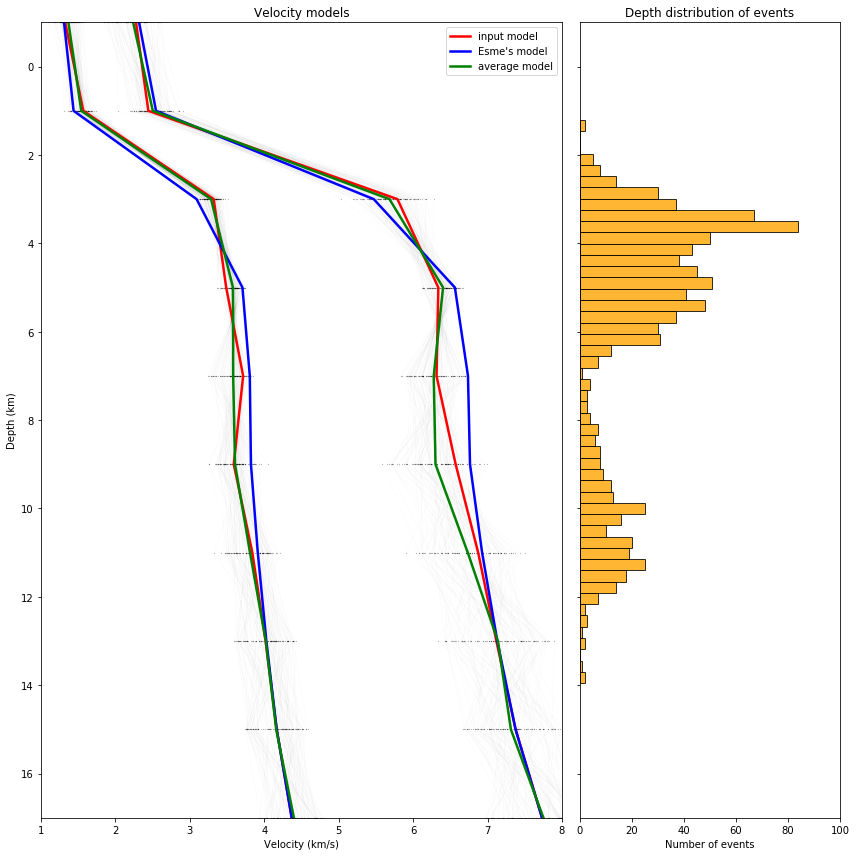

In [8]:
## PLOT THE MODELS

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 12), sharey=True, gridspec_kw={'width_ratios': [2, 1]})

# VELOCITY MODELS

#depth = random_model_dict[0]['depth']
#for i in range(len(p_grid_files)):
    #ax1.plot(random_model_dict[i]['Vp'], depth, marker='o',markersize=0.1, linestyle='-', color="gray")
    #ax1.plot(random_model_dict[i]['Vs'], depth, marker='o',markersize=0.1, linestyle='-', color="gray")
    #ax1.scatter(random_model_dict[i]['Vp'], depth, marker='o', color="gray")
    #ax1.scatter(random_model_dict[i]['Vs'], depth, marker='o', color="gray")

depth = inverted_model_dict[0]['depth']
for i in range(len(p_grid_files)):
    ax1.plot(inverted_model_dict[i]['Vp'], depth, marker='o',markersize=0.1, linewidth=0.01, linestyle='-', color="black")
    ax1.plot(inverted_model_dict[i]['Vs'], depth, marker='o',markersize=0.1, linewidth=0.01, linestyle='-', color="black")

ax1.plot(initial_model_df['Vp'], initial_model_df['depth'], marker='o',markersize=0.1, linestyle='-', linewidth=2.5, label="input model", color='red')
ax1.plot(initial_model_df['Vs'], initial_model_df['depth'], marker='o',markersize=0.1, linestyle='-', linewidth=2.5, color='red')

ax1.plot(esme_df['Vp'], esme_df['depth'], marker='o',markersize=0.2, linestyle='-', linewidth=2.5, label="Esme's model", color='blue')
ax1.plot(esme_df['Vs'], esme_df['depth'], marker='o',markersize=0.2, linestyle='-', linewidth=2.5, color='blue')

ax1.plot(average_model['Vp'], average_model['depth'], marker='o',markersize=0.2, linestyle='-', linewidth=2.5, label="average model", color='green')
ax1.plot(average_model['Vs'], average_model['depth'], marker='o',markersize=0.2, linestyle='-', linewidth=2.5, color='green')

ax1.set_ylim(-1,17)
ax1.set_title('Velocity models')
ax1.invert_yaxis()
ax1.set_xlim(1,8)
ax1.set_xlabel('Velocity (km/s)')
ax1.set_ylabel('Depth (km)')
ax1.legend()

# DEPTH DISTRIBUTION OF EVENTS

all_picks_df = pd.read_csv(picks_path, sep=r'\s+', skiprows=0, header=0)
all_picks_df.drop(["Weight", "NLL_res"], axis=1, inplace=True)

grouped_df = all_picks_df.groupby("event_ID")
event_df = pd.DataFrame(data=None, columns=["event_ID", "depth"])

for group_name, group_data in grouped_df:
    
    evname = str(group_name)
    evdepth = group_data["depth"].iloc[0]
    data_row = {"event_ID": str(evname), "depth": float(evdepth)}
    
    event_df = event_df.append(data_row, ignore_index=True)

ax2.hist(event_df['depth'], bins=50, orientation='horizontal', color='orange', edgecolor='k', alpha=0.8, align='right')
ax2.set_xlabel('Number of events')
ax2.set_title('Depth distribution of events')
ax2.set_ylim(-1, 17)
ax2.set_xlim(0, 100)
ax2.invert_yaxis()

plt.tight_layout()

fig.show()

In [9]:
if calc_avg == True:

    Vp = average_model["Vp"]
    Vs = average_model["Vs"]
    depth = average_model["depth"]

    # add top and bottom values to the model for FMTOMO
    top_row = {"depth": -10, "Vp": Vp[0], "Vs": Vs[0]}    
    bottom_row = {"depth": 20, "Vp": Vp[(len(Vp)-1)], "Vs": Vs[(len(Vs)-1)]}
    
    average_model = average_model.append(bottom_row, ignore_index=True)
    top_df = pd.DataFrame([top_row])
    final_df = top_df.append(average_model, ignore_index=True)
    average_model = final_df
    print(average_model)
    
    # save the random model into file
    average_model.to_csv(os.path.join(models_path, avg_name), index=False, header=False, sep="\t", float_format="%.6f")

    depth        Vp        Vs
0   -10.0  2.238697  1.369283
1    -1.0  2.238697  1.369283
2     1.0  2.502592  1.541465
3     3.0  5.682092  3.285200
4     5.0  6.402104  3.580013
5     7.0  6.276478  3.582382
6     9.0  6.300538  3.607416
7    11.0  6.734331  3.808577
8    13.0  7.138726  4.020255
9    15.0  7.313221  4.160490
10   17.0  7.750456  4.398079
11   20.0  7.750456  4.398079


In [10]:
#import pickle

# Save the dictionary to a file using pickle
#with open(os.path.join(models_path, "2kg_inverted_models.pickle"), 'wb') as pickle_file:
#    pickle.dump(inverted_model_dict, pickle_file)